# Introducción a los algoritmos de aprendizaje supervisado y no supervisado

## 1. Introducción al machine learning supervisado

En estos algoritmos, el modelo aprende a partir de un conjunto de datos etiquetados, es decir, cada entrada tiene una salida correspondiente. El objetivo es que el modelo pueda predecir la salida para nuevas entradas basándose en el aprendizaje previo. Estos modelos se pueden aplicar tanto en clasificación de fotos, reconocimiento de voz, predicción de precios, entre otros.

### 1.1 Presentación del problema y Análisis de datos

Cargamos el dataset de kaggle [Housing Price](https://www.kaggle.com/datasets/saurabhbadole/housing-price-data)
- Información sobre las casas y su precio
- Objetivo: predecir el precio de una casa en función de sus características

> Other datasets:
-  [Perth House Prices](https://www.kaggle.com/datasets/syuzai/perth-house-prices)
-  [Boston Housing Prices](https://www.kaggle.com/datasets/vikrishnan/boston-house-prices)

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

RNG = 42

#### 1.1.1 Análisis exploratorio de datos (EDA)

In [47]:
df_houses = pd.read_csv('datasets/Housing_Price_Data.csv')
print(f"Tamaño del dataset {df_houses.shape}")
df_houses.head()

Tamaño del dataset (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


- Comprobamos el tamaño del dataset y visualizamos las primeras filas. Vemos que no hay muchos datos así que tenemos que tenerlo en cuenta a la hora de entrenar el modelo.
- Tenemos varias características numéricas y categóricas.

In [48]:
df_houses.isnull().sum() * 100 / len(df_houses) # len == shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

Comprobamos si hay valores nulos y planteamos como limpiarlo (no hay)

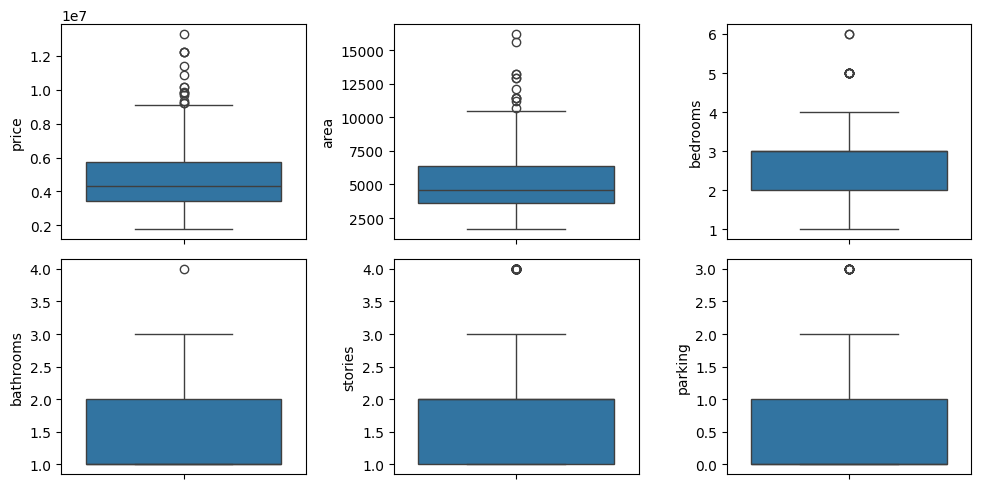

In [49]:
fig, ax = plt.subplots(2,3, figsize=(10, 5))
numeric_cols = df_houses.select_dtypes(include=['int64', 'float64']).columns
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df_houses[col], ax=ax[i//3, i%3])
plt.tight_layout()
plt.show()

- Comprobamos ahora outliers en las características numéricas. Vemos que hay varios outliers en price, area y bedrooms. Podríamos optar por no eliminarlos, realizar el modelo con y sin ellos para ver la diferencia.
- Vemos la distribución de los datos para ver si los valores son totalmente dispares o si siguen una distribución concreta.

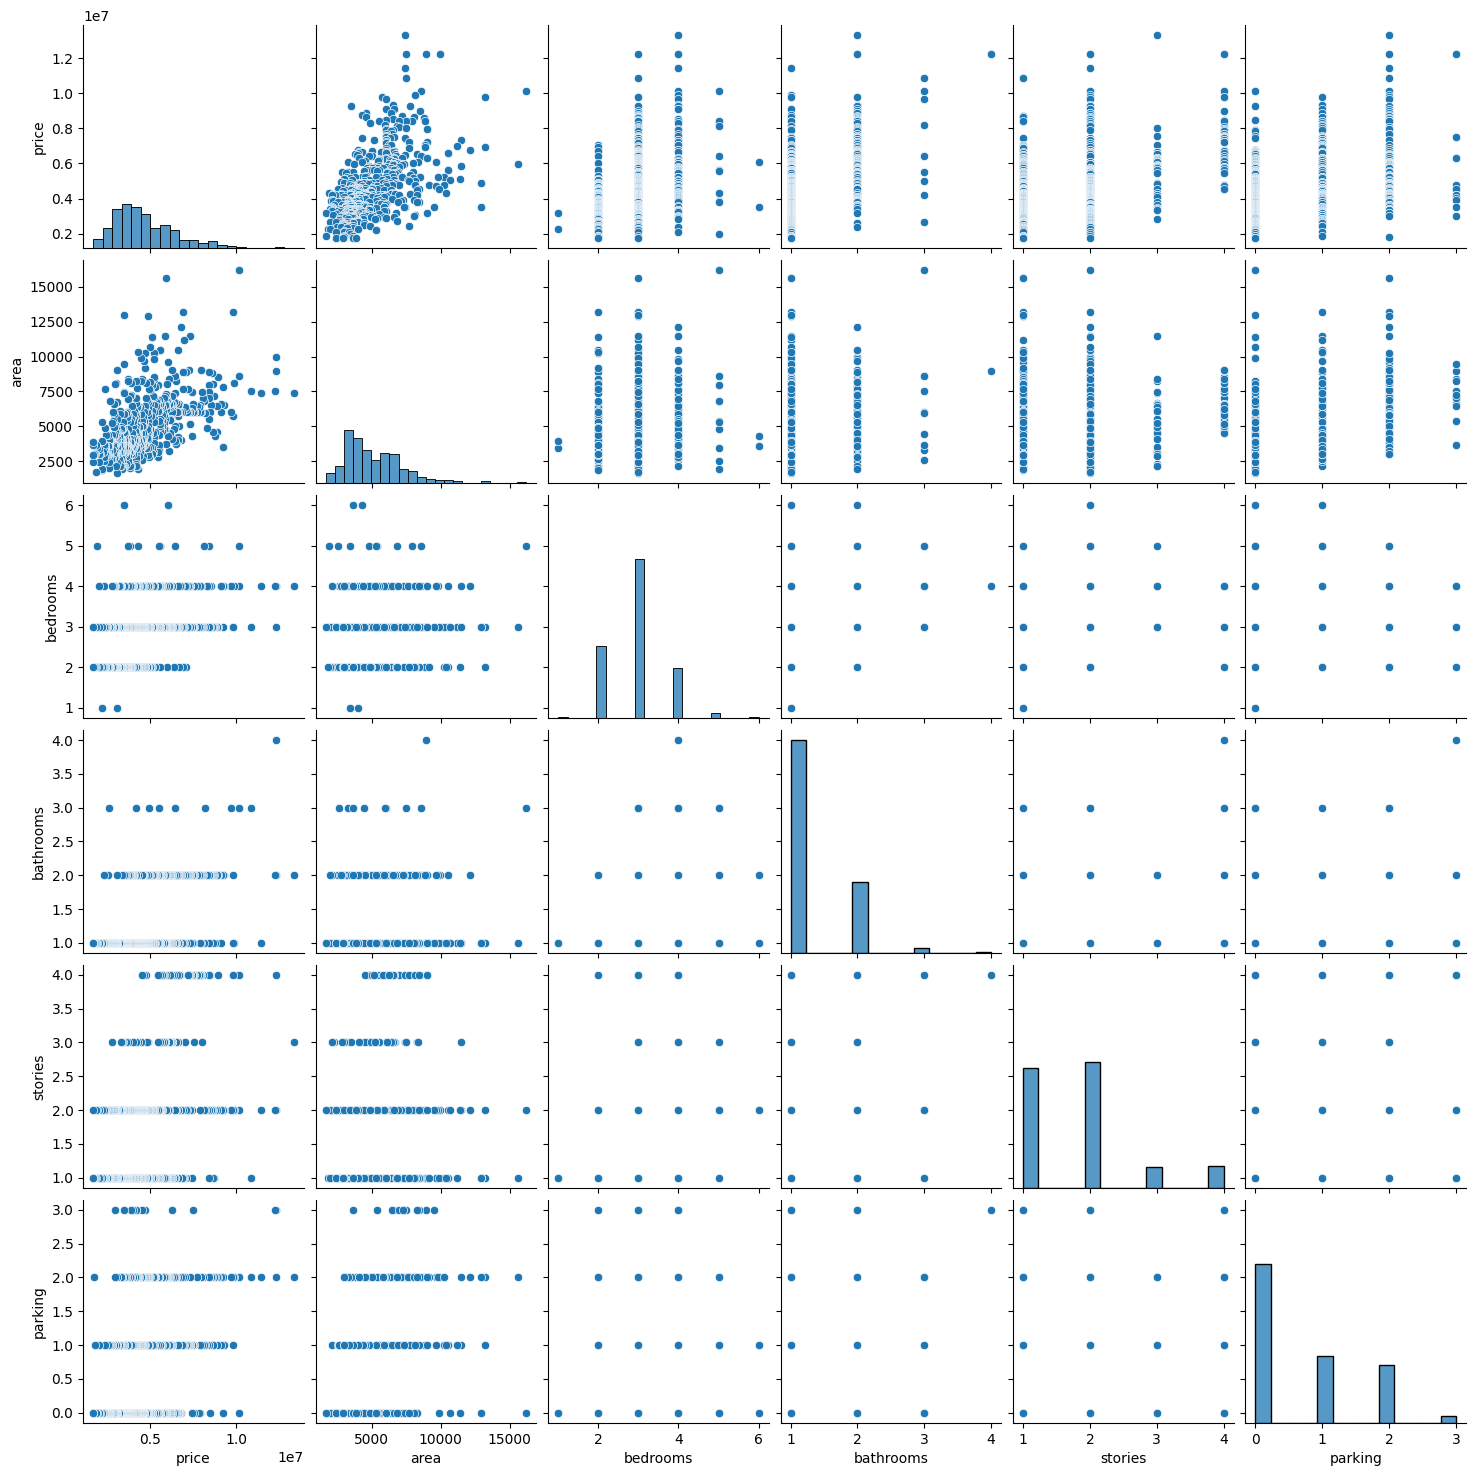

In [50]:
# Este método es sobre todo útil en problemas de clasificación, pero en regresión también puede ser útil
# para ver distribución e histogramas de las variables numéricas. Para datos categóricos, tiene
# demasiadas combinaciones posibles, es en valores continuos donde más sentido tiene. Para
# datos categóricos, es mejor usar countplots o similares.
sns.pairplot(df_houses)
plt.show()

- Decidimos no eliminar los outliers ya que en el contexto del problema pueden ser datos válidos (casas muy caras o muy baratas) además de que el dataset es pequeño y perderíamos demasiada información.

Convertimos las variables categóricas a numéricas
> Para categorías yes/no, usamos 1/0. Para furnishing_status, usamos one-hot encoding para no introducir un orden artificial y puesto que tiene 3+ categorías.

In [51]:
furnishingstatus_dummies = pd.get_dummies(df_houses["furnishingstatus"], dtype=int)
df_houses.drop(columns=["furnishingstatus"], inplace=True)
df_houses = pd.concat([df_houses, furnishingstatus_dummies], axis=1)

categorial_cols = df_houses.select_dtypes(include=['object']).columns

def binary_mapping(x: pd.Series) -> pd.Series:
    print(f"Mapping column: {x.name}")
    return x.map({'yes': 1, 'no': 0})

df_houses[categorial_cols] = df_houses[categorial_cols].apply(binary_mapping)
df_houses.head()

Mapping column: mainroad
Mapping column: guestroom
Mapping column: basement
Mapping column: hotwaterheating
Mapping column: airconditioning
Mapping column: prefarea


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


- Preparamos los subconjuntos de entrenamiento y prueba
- Normalizamos las características numéricas con MinMaxScaler, que escala los valores al rango [0, 1]. Esto es especialmente útil para algoritmos que son sensibles a la escala de los datos, como la regresión lineal y los métodos basados en distancias.

> En nuestro caso por ejemplo el precio de la casa está en dólares, el área en metros cuadrados y el número de habitaciones es un entero pequeño. Si no normalizamos, las características con rangos más grandes (como el precio y el área) podrían dominar el proceso de aprendizaje (los pesos asignados), lo que llevaría a un modelo menos efectivo. Al normalizar, aseguramos que todas las características contribuyan de manera equilibrada al entrenamiento del modelo.

> Pero podría haber otros casos en los que no sea necesario normalizar, por ejemplo si todas las características ya están en la misma escala o si el modelo que vamos a usar no es sensible a la escala de los datos (como los árboles de decisión) o si es importante mantener esa escala para la interpretabilidad del modelo. Podríamos entrenar el modelo con y sin normalización para ver la diferencia en el rendimiento.

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_houses[numeric_cols] = scaler.fit_transform(df_houses[numeric_cols])
df_houses.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,1.000000,0.396564,0.6,0.333333,0.666667,1,0,0,0,1,0.666667,1,1,0,0
1,0.909091,0.502405,0.6,1.000000,1.000000,1,0,0,0,1,1.000000,0,1,0,0
2,0.909091,0.571134,0.4,0.333333,0.333333,1,0,1,0,0,0.666667,1,0,1,0
3,0.906061,0.402062,0.6,0.333333,0.333333,1,0,1,0,1,1.000000,1,1,0,0
4,0.836364,0.396564,0.6,0.000000,0.333333,1,1,1,0,1,0.666667,0,1,0,0


Creamos los conjuntos de entrenamiento y prueba (80% - 20%)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_houses.drop(columns=['price']),
    df_houses['price'],
    test_size=0.2,
    random_state=RNG
)

### 1.2 Algoritmos de regresión lineal

Con nuestros datos limpios y preparados, podemos empezar a modelar. Para modelos clásicos, usaremos sklearn. El uso de sus modelos es estándar y similar en todos los casos.
- Cargar el modelo
- Entrenar el modelo con los datos de entrenamiento (fit)
- Comprobar el score del modelo con los datos de prueba (score) / métricas de error (MAE, MSE, RMSE)
- Utilizarlo para predecir nuevos datos (predict)

#### 1.2.1 Regresión lineal simple

In [54]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [55]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = lr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred) * 100:.2f} % ajuste del modelo")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

R2 Score: 65.29 % ajuste del modelo
MAE: 0.08
RMSE: 0.11


Vemos que tanto MAE como RMSE son pequeños y parecidos, lo que indica que el modelo tiene un buen rendimiento y no hay errores extremadamente grandes en las predicciones.
Pero el R2 es 64%, lo que indica que el modelo no explica completamente la variabilidad de los datos. Podríamos intentar mejorar el modelo con técnicas como la selección de características.

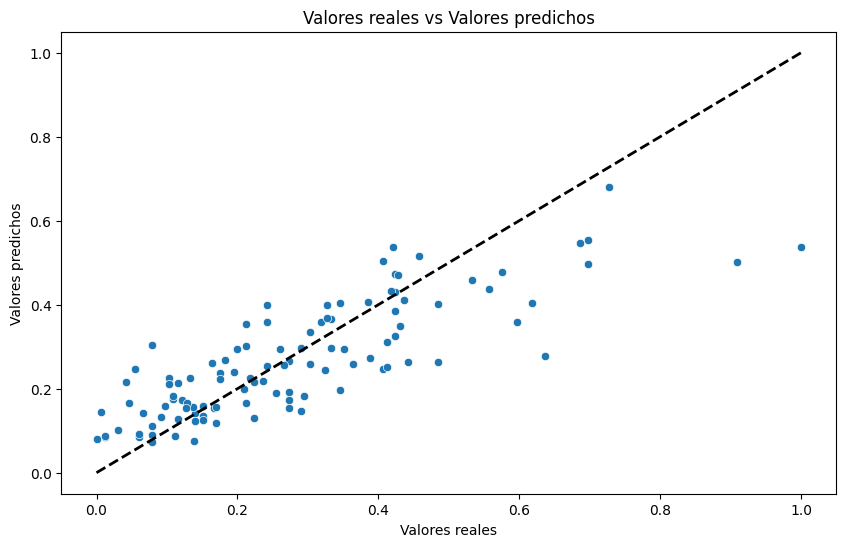

In [56]:
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Valores reales vs Valores predichos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

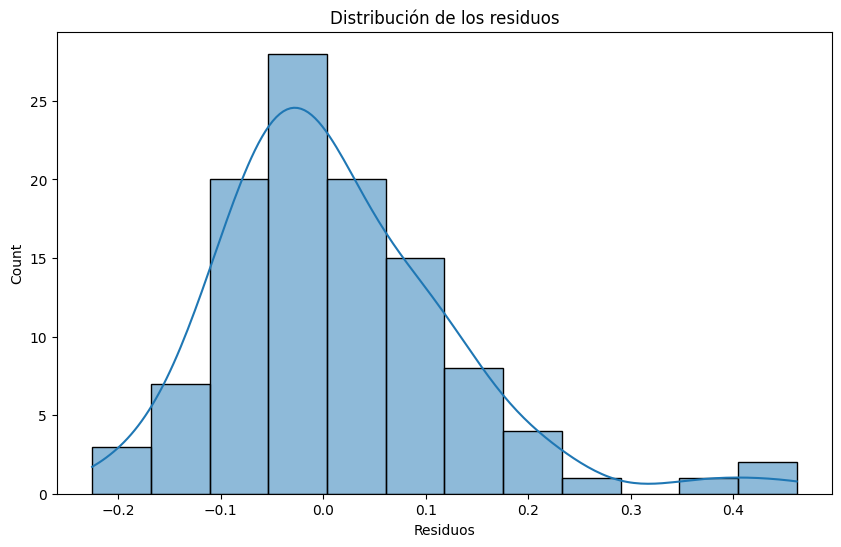

In [57]:
y_residuals = y_test - y_pred
fig = plt.figure(figsize=(10, 6))
sns.histplot(y_residuals, kde=True)
plt.xlabel("Residuos")
plt.title("Distribución de los residuos")
plt.show()

- Vemos la predicción frente a los valores reales. Apreciamos cierta linealidad.
- Calculamos también los residuos del modelo (diferencia entre valores reales y predichos) y vemos que siguen una distribución normal, lo que indica que el modelo es adecuado. No vemos picos extremos en los residuos, lo que indica que no hay errores grandes en las predicciones.

#### 1.2.1.1 Selección de características con RFE (Recursive Feature Elimination)

Aplicamos una técnica de selección de características (RFE) para mejorar el modelo. Seleccionamos las características más importantes viendo primero el ranking de las características.

In [58]:
from sklearn.feature_selection import RFE

# No definimos selected_features, ya que queremos el ranking completo
rfe = RFE(lr)
rfe = rfe.fit(X_train, y_train)
ranking = rfe.ranking_
print("Ranking de características:")
for i, col in enumerate(X_train.columns):
    print(f"{col}: {ranking[i]}, supported: {rfe.support_[i]}")

# Support indica las características seleccionadas

Ranking de características:
area: 1, supported: True
bedrooms: 4, supported: False
bathrooms: 1, supported: True
stories: 1, supported: True
mainroad: 3, supported: False
guestroom: 6, supported: False
basement: 2, supported: False
hotwaterheating: 1, supported: True
airconditioning: 1, supported: True
parking: 1, supported: True
prefarea: 1, supported: True
furnished: 7, supported: False
semi-furnished: 8, supported: False
unfurnished: 5, supported: False


In [59]:
selected_col = X_train.columns[rfe.support_]
print(f"Características seleccionadas: {selected_col.tolist()}")
not_selected_col = X_train.columns[~rfe.support_]
print(f"Características no seleccionadas: {not_selected_col.tolist()}")

Características seleccionadas: ['area', 'bathrooms', 'stories', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
Características no seleccionadas: ['bedrooms', 'mainroad', 'guestroom', 'basement', 'furnished', 'semi-furnished', 'unfurnished']


Si creemos que uno de los no seleccionados es importante, podemos volver a entrenar el modelo incluyendo esa característica y ver si mejora el rendimiento.

In [60]:
lr = LinearRegression()
lr.fit(X_train[selected_col], y_train)

y_pred = lr.predict(X_test[selected_col])
print(f"R2 Score (RFE): {r2_score(y_test, y_pred) * 100:.2f} % ajuste del modelo")
print(f"MAE (RFE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE (RFE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

R2 Score (RFE): 62.24 % ajuste del modelo
MAE (RFE): 0.09
RMSE (RFE): 0.12


Vemos que el R2 score ha bajado y tenemos más errores, esto se debe a que no tenemos suficientes datos para entrenar el modelo con menos características. En este caso, podríamos optar por quedarnos con el modelo original o probar otras técnicas de selección de características o regularización para mejorar el modelo sin perder demasiada información.

Decidimos intentar otros modelos.

### 1.2.2 Modelo de regresión Lasso

Modelo de regresión lineal con regularización L1 (Lasso) para mejorar la generalización del modelo y reducir el sobreajuste. L1 penaliza la suma absoluta de los coeficientes, lo que puede llevar a que algunos coeficientes sean exactamente cero, eliminando así características irrelevantes del modelo.

In [61]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, random_state=RNG)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print(f"R2 Score (Lasso): {r2_score(y_test, y_pred) * 100:.2f} % ajuste del modelo")
print(f"MAE (Lasso): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE (Lasso): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

R2 Score (Lasso): 65.16 % ajuste del modelo
MAE (Lasso): 0.08
RMSE (Lasso): 0.11


Vemos que los resultados son similares, viendo que los resultados convergen razonamos que no nos vale con cambiar sólo el modelo, sino que tenemos que ajustar los hiperparámetros o no tenemos suficientes datos para mejorar el modelo.

### 1.3 Algoritmos de clasificación - árboles de decisión

#### 1.3.1 Iris Dataset

Para algoritmos de clasificación, usaremos el dataset [Iris](https://archive.ics.uci.edu/ml/datasets/Iris) que es un clásico en machine learning.

In [62]:
df_iris = pd.read_csv('datasets/iris.csv')
print(f"Tamaño del dataset {df_iris.shape}")
df_iris.head()

Tamaño del dataset (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


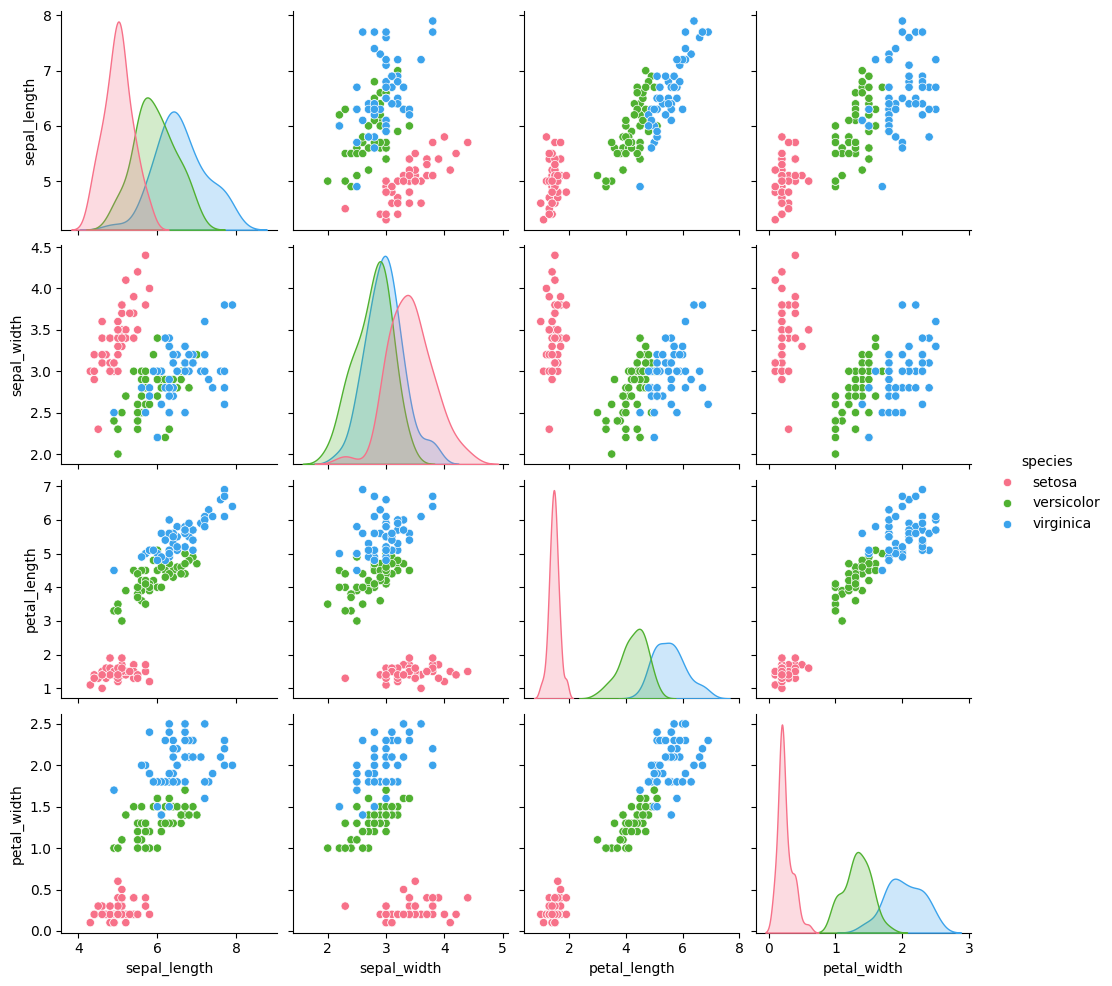

In [63]:
sns.pairplot(df_iris, hue='species', palette='husl')
plt.show()

Vemos que la categoría setosa es fácilmente separable de las otras dos, mientras que versicolor y virginica tienen más solapamiento, pero no presentan demasiada dificultad para separarlas con un buen modelo.

Comprobaremos ahora si las clases están balanceadas, lo cual es importante para evitar sesgos en el modelo.

In [64]:
df_iris['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

No hay desbalance. Podemos tolerar cierto desbalance, pero sólo si el dataset es muy grande, ya que podríamos eliminar datos de la clase mayoritaria.

El dataset ya está limpio, sin valores nulos ni outliers evidentes, por lo que podemos proceder a entrenar los modelos de clasificación directamente.

In [65]:
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df_iris.drop(columns=['species']),
    df_iris['species'],
    test_size=0.2,
    random_state=RNG
)
clf = tree.DecisionTreeClassifier(random_state=RNG)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 100.00 %
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


Tener un resultado de 100% en un dataset tan pequeño y sencillo puede ser una señal de sobreajuste, especialmente si no se ha realizado una validación cruzada adecuada. Sin embargo, en este caso particular del dataset Iris, es posible que un modelo simple como el árbol de decisión pueda lograr una precisión perfecta debido a la naturaleza linealmente separable de las clases en el espacio de características.

Una ventaja de los árboles de decisión es que podemos visualizarlos fácilmente para entender cómo toman decisiones.

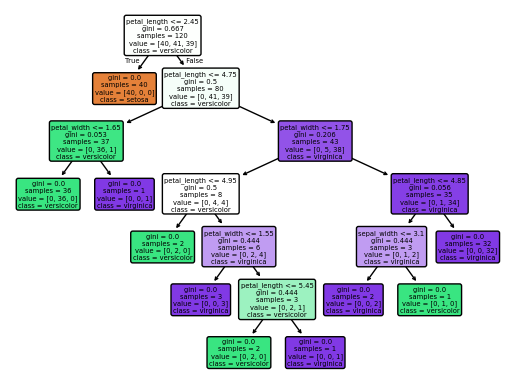

In [66]:
tree.plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.show()

#### 1.3.2 Titanic Dataset
Ahora probaremos con un dataset más complejo, el [Titanic](https://www.kaggle.com/datasets/yasserh/titanic-dataset).

In [67]:
df_titanic = pd.read_excel('datasets/titanic.xls')
print(f"Tamaño del dataset {df_titanic.shape}")
df_titanic.head()

Tamaño del dataset (1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Vemos que hay varias características categóricas y numéricas. Además, hay varios valores nulos en las algunas columnas. También hay columnas que no aportan información relevante para el modelo (como el nombre o el homedest) que eliminaremos.

In [68]:
df_titanic['survived'].value_counts()

survived
0    809
1    500
Name: count, dtype: int64

Vemos que hay un desbalance en las clases, con más personas que no sobrevivieron que las que sí. Pero el dataset es pequeño y no tenemos un desbalance extremo, por lo que podemos proceder sin hacer nada especial, además que tiene sentido en el contexto del problema (más gente murió que sobrevivió).

Procedemos a limpiar y preparar los datos

In [69]:
# Quitamos columnas irrelevantes
df_titanic_clean = df_titanic.drop(columns=['name', 'ticket', 'cabin', 'home.dest', 'body', 'boat'])

# Convertimos las variables categóricas a numéricas usando factorize
df_titanic_clean['sex'] = pd.factorize(df_titanic_clean['sex'])[0]
df_titanic_clean['embarked'] = pd.factorize(df_titanic_clean['embarked'])[0]

df_titanic_clean.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,0
1,1,1,1,0.9167,1,2,151.5500,0
2,1,0,0,2.0000,1,2,151.5500,0
3,1,0,1,30.0000,1,2,151.5500,0
4,1,0,0,25.0000,1,2,151.5500,0


comprobamos porcentaje de valores nulos en cada columna para decidir cómo manejarlos

In [70]:
for col in df_titanic_clean.columns:
    null_percentage = df_titanic_clean[col].isnull().sum() * 100 / len(df_titanic_clean)
    print(f"{col}: {null_percentage:.2f} % valores nulos")

pclass: 0.00 % valores nulos
survived: 0.00 % valores nulos
sex: 0.00 % valores nulos
age: 20.09 % valores nulos
sibsp: 0.00 % valores nulos
parch: 0.00 % valores nulos
fare: 0.08 % valores nulos
embarked: 0.00 % valores nulos


In [71]:
df_titanic_clean['age'] = df_titanic_clean['age'].fillna(df_titanic_clean['age'].mean())
df_titanic_clean['fare'] = df_titanic_clean['fare'].fillna(df_titanic_clean['fare'].mean())

Decidimos rellenar los valores nulos de age y fare con la media de cada columna, ya que no son muchos y es una forma sencilla de manejar los nulos sin perder demasiada información. Podríamos usar también la mediana o la moda pero es solo un ejemplo sencillo.

Vemos la distribución

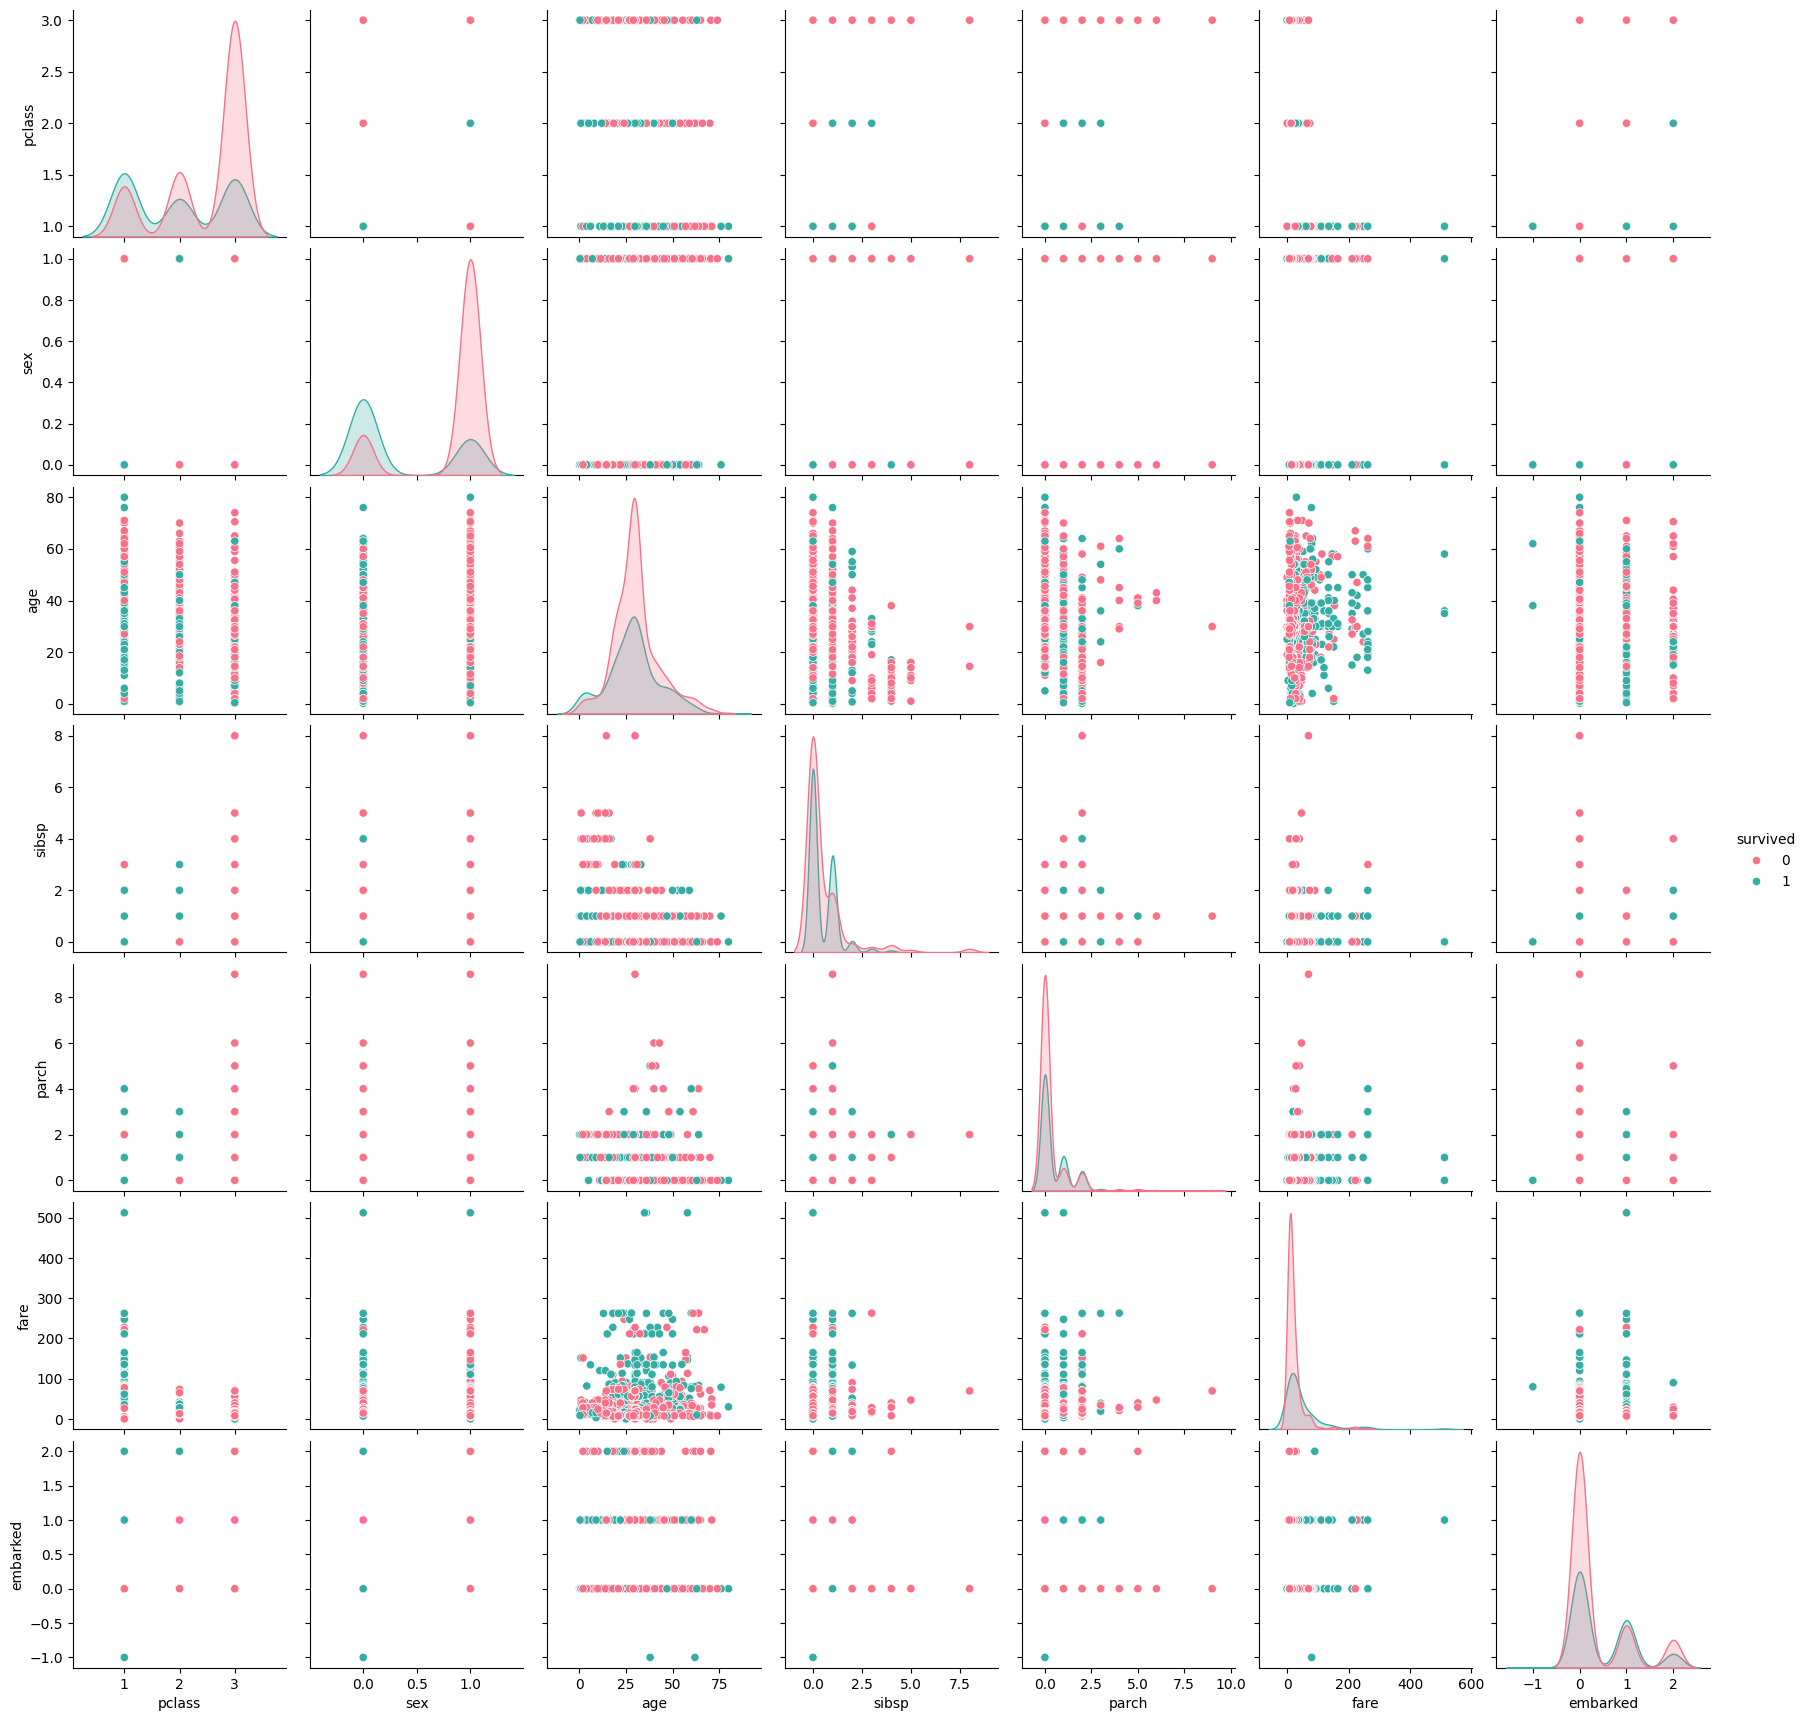

In [72]:
sns.pairplot(df_titanic_clean, hue='survived', palette='husl')
plt.show()

Como son muchas variables categóricas no aporta mucho visualizarlas con pairplot, pero podemos ver que todos los datos están bastante mezclados, por lo que el modelo tendrá que ser más complejo para separar las clases.

Dividimos los datos en entrenamiento y prueba (80%-20%) y entrenamos el modelo de árbol de decisión.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic_clean.drop(columns=['survived']),
    df_titanic_clean['survived'],
    test_size=0.2,
    random_state=RNG
)
clf = tree.DecisionTreeClassifier(random_state=RNG)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 79.39 %
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       144
           1       0.81      0.71      0.76       118

    accuracy                           0.79       262
   macro avg       0.80      0.79      0.79       262
weighted avg       0.80      0.79      0.79       262

Confusion Matrix:
[[124  20]
 [ 34  84]]


Con la matrix de confusión podemos ver mejor los resultados del modelo más allá del accuracy.

[Text(0, 0.5, 'Did not survive'), Text(0, 1.5, 'Survived')]

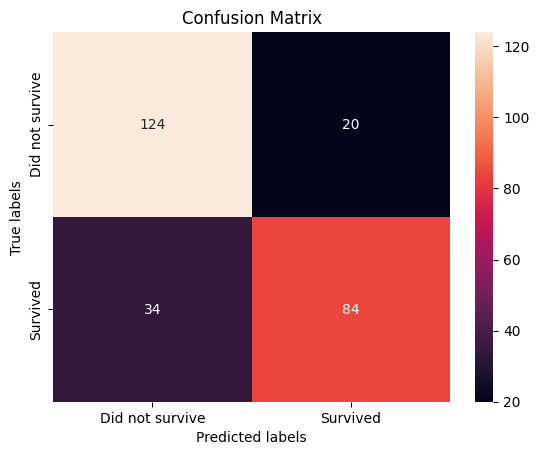

In [74]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Did not survive', 'Survived'])
ax.yaxis.set_ticklabels(['Did not survive', 'Survived'])

- 74% precision for "didn't survive" / label 0 and 75% precision for "survived" / label 1. Vemos que el modelo tiene un rendimiento decente, pero hay margen de mejora, especialmente en la clase de personas que sobrevivieron, donde hay más falsos negativos (personas que sobrevivieron pero el modelo predijo que no).
- Accuracy: 79.39%

> Accuracy es útil cuando quieres rápidamente ver lo bien o mal que lo ha hecho el modelo. Pero para afinar y mejorar el modelo (hiperparámetros) la matrix de confusión es más informativa, ya que nos permite ver los tipos de errores que está cometiendo el modelo (falsos positivos y falsos negativos) y ajustar en consecuencia.

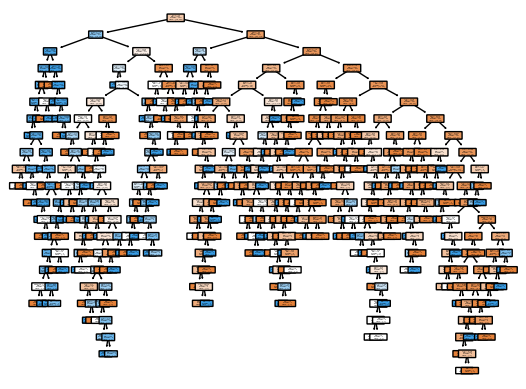

In [75]:
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['Did not survive', 'Survived'], filled=True, rounded=True)
plt.show()

Para modelos más grandes el tree puede ser muy grande y difícil de interpretar.

In [76]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10, random_state=RNG)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 77.10 %
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       144
           1       0.85      0.59      0.70       118

    accuracy                           0.77       262
   macro avg       0.79      0.75      0.76       262
weighted avg       0.79      0.77      0.76       262

Confusion Matrix:
[[132  12]
 [ 48  70]]


Si aumentamos el parámetro min_samples_leaf vemos que el árbol es más pequeño y sencillo, pero el accuracy baja un poco. Hay que buscar un equilibrio entre complejidad e interpretabilidad del modelo.

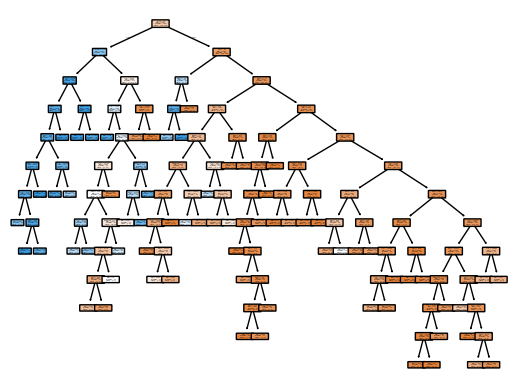

In [77]:
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['Did not survive', 'Survived'], filled=True, rounded=True)
plt.show()

In [78]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=RNG)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 77.86 %
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       144
           1       0.81      0.67      0.73       118

    accuracy                           0.78       262
   macro avg       0.78      0.77      0.77       262
weighted avg       0.78      0.78      0.78       262

Confusion Matrix:
[[125  19]
 [ 39  79]]


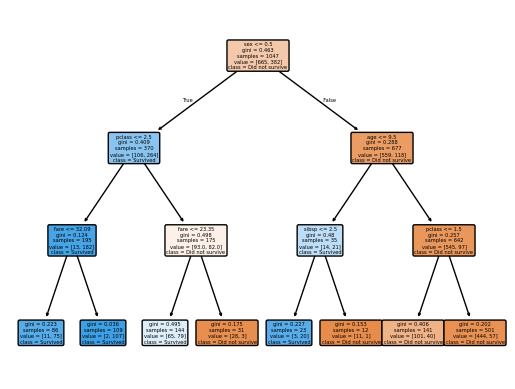

In [79]:
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['Did not survive', 'Survived'], filled=True, rounded=True)
plt.show()

Otra opción es limitar la profundidad máxima del árbol con max_depth. También reduce la complejidad del árbol y mejora la interpretabilidad, pero puede reducir el rendimiento si se limita demasiado. Útil para presentaciones o explicaciones a usuarios no técnicos.

### 1.3.3 Otros algoritmos de clasificación (Random Forest, SVM, KNN, etc.)


#### 1.3.3.1 Random Forest
Random Forest es un conjunto de árboles de decisión que mejora la precisión y reduce el sobreajuste al promediar las predicciones de múltiples árboles entrenados con diferentes subconjuntos de datos y características. Es robusto y maneja bien datos ruidosos y desbalanceados.

In [92]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=RNG)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred))

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       144
           1       0.81      0.70      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262



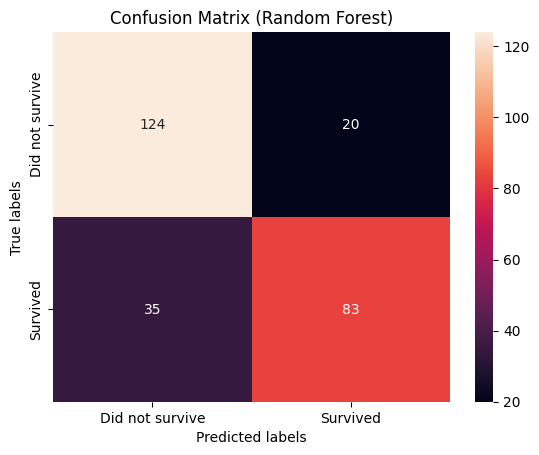

In [93]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix (Random Forest)")
ax.xaxis.set_ticklabels(['Did not survive', 'Survived'])
ax.yaxis.set_ticklabels(['Did not survive', 'Survived'])
plt.show()

Vemos que no cambia en exceso la accuracy. Podemos ver comparando la matrix de confusión que presenta valores similares en cuanto a falsos positivos y negativos.

Podemos ver cada árbol individualmente (mostramos los dos primeros) para entender cómo toman decisiones.

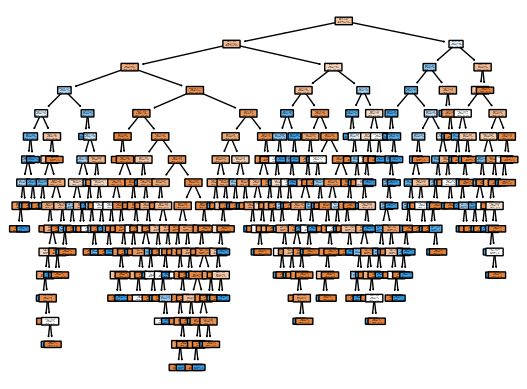

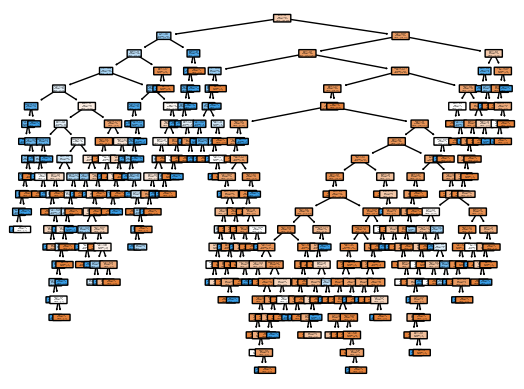

In [94]:
for decision_tree in rf.estimators_[:2]:
    tree.plot_tree(decision_tree, feature_names=X_train.columns, class_names=['Did not survive', 'Survived'], filled=True, rounded=True)
    plt.show()

#### 1.3.3.2 SVM
Dejando atrás los modelos de Ensemble, vemos que Support Vector Machines (SVM) son algoritmos de clasificación que encuentran el hiperplano que mejor separa las clases en el espacio de características. Son efectivos en espacios de alta dimensión y son robustos frente a sobreajuste, especialmente con el uso de kernels.

In [95]:
from sklearn.svm import SVC
svc = SVC(random_state=RNG, kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred))

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.78      0.64      0.70       118

    accuracy                           0.76       262
   macro avg       0.76      0.74      0.75       262
weighted avg       0.76      0.76      0.75       262



El porcentaje ha caído un poco, si el problema tiene mucha dimensionalidad, muchas características va a tardar en converger. A más datos, más clases y le cuesta más encontrar el hiperplano óptimo.
> Hiperplano de dos categorías es una línea que separa dos clases en un espacio bidimensional. En espacios de mayor dimensión, este hiperplano se convierte en un plano o un hiperplano que divide el espacio en regiones correspondientes a cada clase.

> Incluso usando GPU, son algoritmos que tardan mucho tanto en entrenamiento como en predicción.

Volviendo al dataset Iris podemos ver la representación del mapa con las zonas donde tenemos las diferents categorías según el modelo SVM entrenado.
> Con el dataset del Titanic tardaría muchísimo.

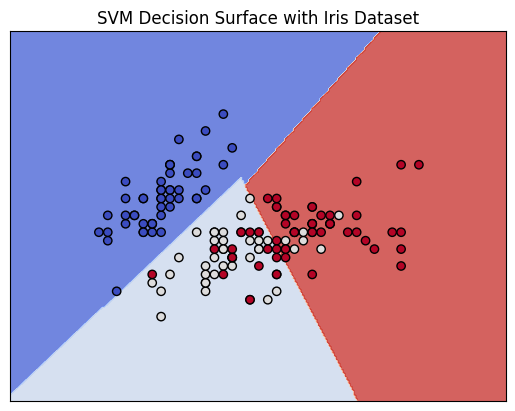

In [99]:
df_iris = pd.read_csv('datasets/iris.csv')
X = np.array(df_iris)[:, :2]  # Usamos solo las dos primeras características para visualización
y = np.array(pd.factorize(df_iris['species'])[0])
h = .02  # step size in the mesh
C = 1.0  # SVM regularization parameter

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

title = "SVM Decision Surface with Iris Dataset"
svc = SVC(kernel='linear', C=C, random_state=RNG)
svc.fit(X, y)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(title)
plt.show()

#### 1.3.3.3 kNN

kNN (k-Nearest Neighbors) es un algoritmo de clasificación basado en la proximidad de los datos. Clasifica una nueva instancia basándose en las clases de sus k vecinos más cercanos en el espacio de características. Es simple y efectivo para conjuntos de datos pequeños y medianos, pero puede ser computacionalmente costoso para grandes volúmenes de datos debido a la necesidad de calcular distancias a todos los puntos de entrenamiento durante la predicción.

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Classification Report (kNN):")
print(classification_report(y_test, y_pred))

Classification Report (kNN):
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       144
           1       0.65      0.48      0.55       118

    accuracy                           0.65       262
   macro avg       0.65      0.63      0.63       262
weighted avg       0.65      0.65      0.64       262



Es un algoritmo fácil de entrenar, ya que más que entrenar, lo que hace es almacenar los datos de entrenamiento para luego compararlos con los nuevos datos durante la predicción, busca los vecinos y qué categoría tienen para asignar la categoría al nuevo dato.

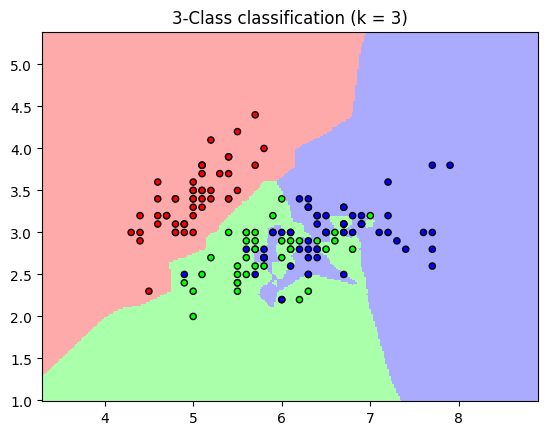

In [105]:
from matplotlib.colors import ListedColormap

X = np.array(df_iris)[:, :2]  # Usamos solo las dos primeras características para visualización
y = pd.factorize(df_iris['species'])[0]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RNG
)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Plot decision boundaries
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot decision boundaries for kNN
# we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.title("3-Class classification (k = 3)")
plt.show()

Al no ser hiperplanos vemos más irregularidades en las zonas de clasificación.